# 🔍 ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

**Objetivo:** Entender os dados e identificar padrões que influenciam a **inadimplência** de clientes.

## 📌 O que vamos descobrir:
- Qualidade dos dados (missing, duplicatas)
- Quem são os inadimplentes?
- Quais variáveis mais impactam o risco de crédito?
- Dados estão prontos para Machine Learning?

In [ ]:
# CÉLULA 1. IMPORTAÇÃO DE BIBLIOTECAS
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
import warnings
warnings.filterwarnings('ignore')

# Configs de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ Bibliotecas carregadas!")

✅ Bibliotecas carregadas!


In [ ]:
# CÉLULA 2. CARREGANDO DADOS DO SQLITE
DB_PATH = 'data/database.db'

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM clientes", conn)
conn.close()

print(f"📊 Dados carregados: {df.shape[0]:,} clientes × {df.shape[1]} variáveis")
print(f"🎯 Target: inadimplente (0=Adimplente, 1=Inadimplente)")

📊 Dados carregados: 100,000 clientes × 17 variáveis
🎯 Target: inadimplente (0=Adimplente, 1=Inadimplente)


In [ ]:
# FEATURE ENGINEERING
print("\n🔧 FEATURE ENGINEERING")

# Criar feature: Renda Per Capita
df['renda_per_capita'] = df['renda_anual'] / (df['numero_dependentes'] + 1)

print(f"✓ Feature criada: renda_per_capita")
print(f"\nEstatísticas da nova feature:")
print(df['renda_per_capita'].describe())

# Comparar correlações
corr_renda_bruta = df[['renda_anual', 'inadimplente']].corr().iloc[0,1]
corr_renda_pc = df[['renda_per_capita', 'inadimplente']].corr().iloc[0,1]

print(f"\nImpacto na correlação com inadimplência:")
print(f"Renda bruta:      {corr_renda_bruta:.4f}")
print(f"Renda per capita: {corr_renda_pc:.4f}")

# EDA da nova feature
print(f"\nInadimplência por faixa de renda per capita:")
df['faixa_renda_pc'] = pd.cut(df['renda_per_capita'], 
                               bins=[0, 10000, 20000, 40000, 1000000],
                               labels=['<10k', '10-20k', '20-40k', '>40k'])
print(df.groupby('faixa_renda_pc')['inadimplente'].agg(['mean', 'count']))

---
# 1️⃣ VISÃO GERAL DOS DADOS
---

In [ ]:
# CÉLULA 3. VISÃO GERAL DOS DADOS
print("📋 Amostra dos dados:\n")
display(df.head())

print("📊 Estrutura do dataset:\n")
df.info()

print("🔍 VERIFICAÇÃO DE QUALIDADE")
print("=" * 60)

# Valores nulos
print(f"\n❓ Valores nulos: {df.isnull().sum().sum()}")

# Duplicatas
duplicatas = df.duplicated().sum()
print(f"🔄 Duplicatas: {duplicatas}")

📋 Amostra dos dados:



,id_cliente,idade,genero,estado_civil,escolaridade,estado,renda_anual,valor_patrimonio,possui_imovel_proprio,possui_carro,ocupacao,numero_dependentes,tempo_emprego_atual,score_serasa_externo,utilizacao_limite_cartao,historico_atraso_90_dias,inadimplente
0,1,47,M,Divorciado,Médio,RJ,9059.86,50709.30,1,0,CLT,2,316,698,11.50,0,0
1,2,37,F,Casado,Médio,PR,40713.82,140855.24,1,1,CLT,1,356,389,65.60,2,1
2,3,49,M,Casado,Médio,BA,72448.95,318428.40,1,1,CLT,3,358,428,0.00,0,0
3,4,62,F,Casado,Médio,SP,42668.42,98233.00,1,1,CLT,3,34,560,77.55,1,0
4,5,36,M,Casado,Superior,RS,46197.81,187751.14,0,1,Autônomo,1,290,475,41.52,0,0


📊 Estrutura do dataset:

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id_cliente                100000 non-null  int64  
 1   idade                     100000 non-null  int64  
 2   genero                    100000 non-null  str    
 3   estado_civil              100000 non-null  str    
 4   escolaridade              100000 non-null  str    
 5   estado                    100000 non-null  str    
 6   renda_anual               100000 non-null  float64
 7   valor_patrimonio          100000 non-null  float64
 8   possui_imovel_proprio     100000 non-null  int64  
 9   possui_carro              100000 non-null  int64  
 10  ocupacao                  100000 non-null  str    
 11  numero_dependentes        100000 non-null  int64  
 12  tempo_emprego_atual       100000 non-null  int64  
 13  score_serasa_externo      10000

### ✋ OBSERVAÇÃO
**100.000 clientes** no Dataset, zero valores nulos e zero duplicatas. Dados prontos para modelagem sem necessidade de limpeza inicial.


---
# 2️⃣ ANÁLISE DO TARGET (INADIMPLÊNCIA)
---

🎯 DISTRIBUIÇÃO DO TARGET

✅ Adimplentes (0): 80,797 (80.8%)
❌ Inadimplentes (1): 19,203 (19.2%)


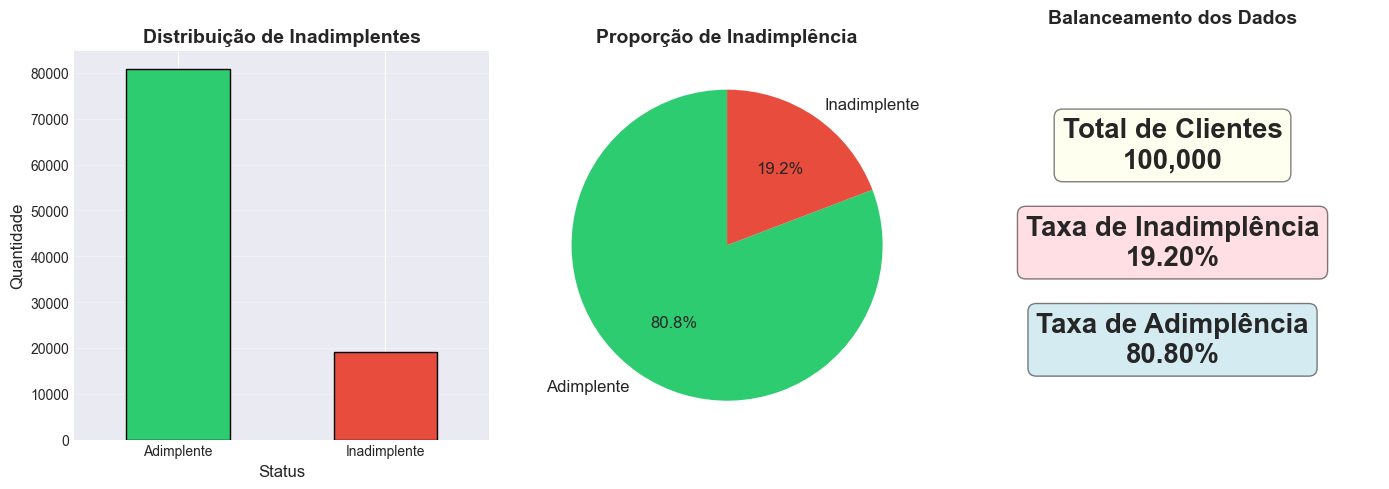

In [ ]:
# CÉLULA 4. DISTRIBUIÇÃO DA INADIMPLÊNCIA
inadimplencia = df['inadimplente'].value_counts()
percentuais = df['inadimplente'].value_counts(normalize=True) * 100

print("🎯 DISTRIBUIÇÃO DO TARGET")
print("=" * 60)
print(f"\n✅ Adimplentes (0): {inadimplencia[0]:,} ({percentuais[0]:.1f}%)")
print(f"❌ Inadimplentes (1): {inadimplencia[1]:,} ({percentuais[1]:.1f}%)")

# Gráficos
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Barras
colors = ['#2ecc71', '#e74c3c']
inadimplencia.plot(kind='bar', ax=ax[0], color=colors, edgecolor='black')
ax[0].set_title('Distribuição de Inadimplentes', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Status', fontsize=12)
ax[0].set_ylabel('Quantidade', fontsize=12)
ax[0].set_xticklabels(['Adimplente', 'Inadimplente'], rotation=0)
ax[0].grid(axis='y', alpha=0.3)

# Pizza
ax[1].pie(inadimplencia, labels=['Adimplente', 'Inadimplente'], autopct='%1.1f%%',
          colors=colors, startangle=90, textprops={'fontsize': 12})
ax[1].set_title('Proporção de Inadimplência', fontsize=14, fontweight='bold')

# Estatísticas
total = len(df)
inadim = percentuais[1]   
adim = percentuais[0]

ax[2].text(
    0.5, 0.7,
    f'Total de Clientes\n{total:,}',
    ha='center',
    fontsize=20,
    fontweight='bold',
    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5)
)

ax[2].text(
    0.5, 0.45,
    f'Taxa de Inadimplência\n{inadim:.2f}%',
    ha='center',
    fontsize=20,
    fontweight='bold',
    bbox=dict(boxstyle='round', facecolor='pink', alpha=0.5)
)

ax[2].text(
    0.5, 0.20,
    f'Taxa de Adimplência\n{adim:.2f}%',
    ha='center',
    fontsize=20,
    fontweight='bold',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
)

ax[2].set_xlim(0, 1)
ax[2].set_ylim(0, 1)
ax[2].axis('off')
ax[2].set_title('Balanceamento dos Dados', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Dados desbalanceados:** 80.8% adimplentes vs 19.2% inadimplentes (proporção 4:1). Precisaremos usar **SMOTE ou ajuste de pesos** no modelo para evitar viés preditivo.

---
# 3️⃣ VARIÁVEIS NUMÉRICAS vs INADIMPLÊNCIA
---

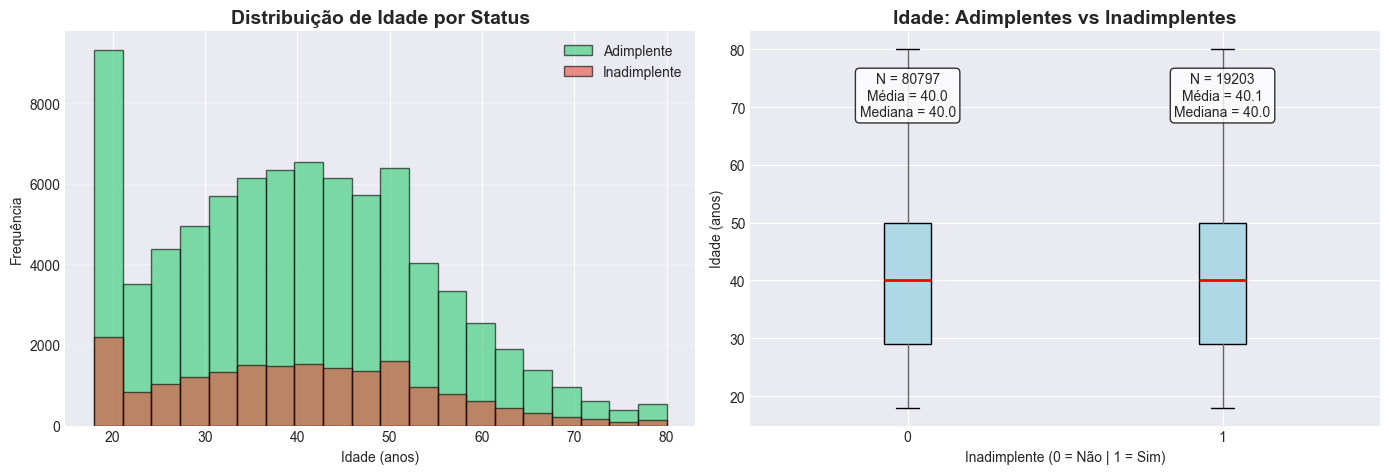

In [ ]:
# CÉLULA 5. IDADE vs INADIMPLÊNCIA
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['idade'].hist(bins=20, alpha=0.6, label='Adimplente', 
                                            color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['idade'].hist(bins=20, alpha=0.6, label='Inadimplente', 
                                            color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Idade por Status', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Idade (anos)', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='idade', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           medianprops=dict(color='red', linewidth=2))
ax[1].set_title('Idade: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Idade (anos)', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Idade NÃO é um fator decisivo:** ambos os grupos têm média de ~40 anos. A inadimplência está mais ligada a fatores financeiros do que demográficos.

---

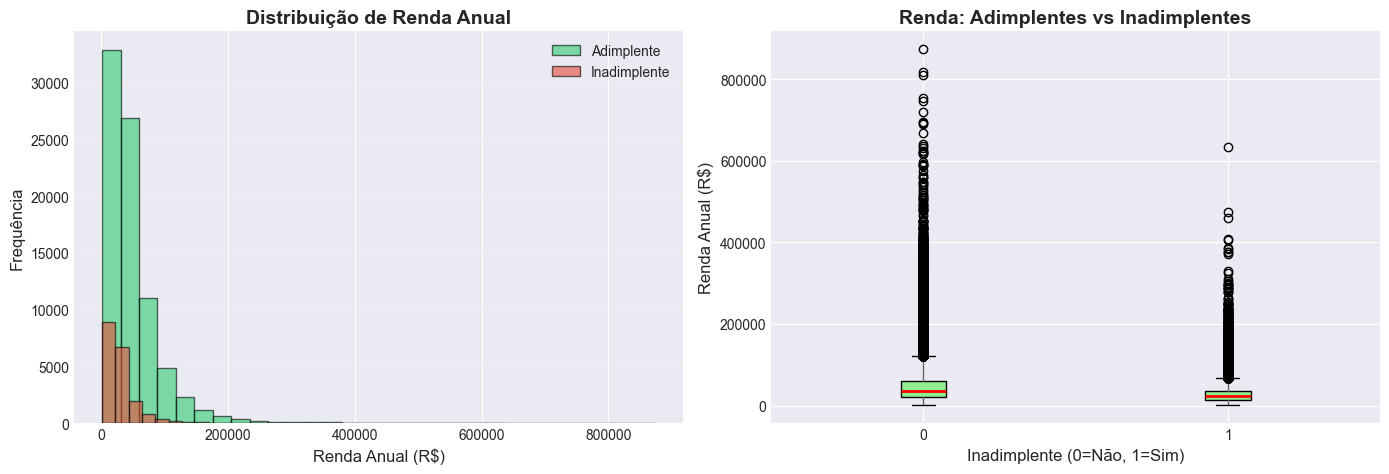

In [ ]:
# CÉLULA 6. RENDA ANUAL vs INADIMPLÊNCIA
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['renda_anual'].hist(bins=30, alpha=0.6, label='Adimplente', 
                                                  color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['renda_anual'].hist(bins=30, alpha=0.6, label='Inadimplente', 
                                                  color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Renda Anual', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Renda Anual (R$)', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='renda_anual', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightgreen', color='black'),
           medianprops=dict(color='red', linewidth=2))
ax[1].set_title('Renda: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Renda Anual (R$)', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Diferença brutal na renda:** inadimplentes ganham **56.7% a menos** (R$ 31k vs R$ 48.5k). Renda baixa é um forte indicador de risco de crédito. Mediana de R$ 23k pode ser um threshold crítico.

---

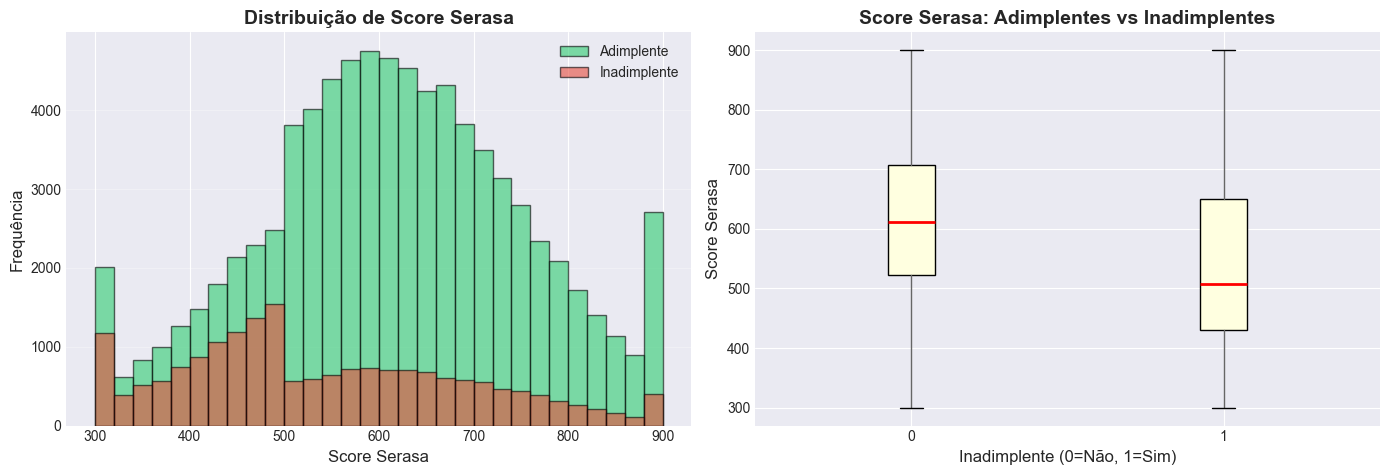

In [ ]:
# CÉLULA 7. SCORE SERASA vs INADIMPLÊNCIA
fix, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['score_serasa_externo'].hist(bins=30, alpha=0.6, label='Adimplente', 
                                                           color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['score_serasa_externo'].hist(bins=30, alpha=0.6, label='Inadimplente', 
                                                           color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Score Serasa', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Score Serasa', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='score_serasa_externo', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightyellow', color='black'),
           medianprops=dict(color='red', linewidth=2))
ax[1].set_title('Score Serasa: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Score Serasa', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Score Serasa é altamente preditivo:** inadimplentes têm score **72 pontos menor** (541 vs 613). **75% dos inadimplentes têm score < 650** — este pode ser um excelente ponto de corte para classificação de risco.

---

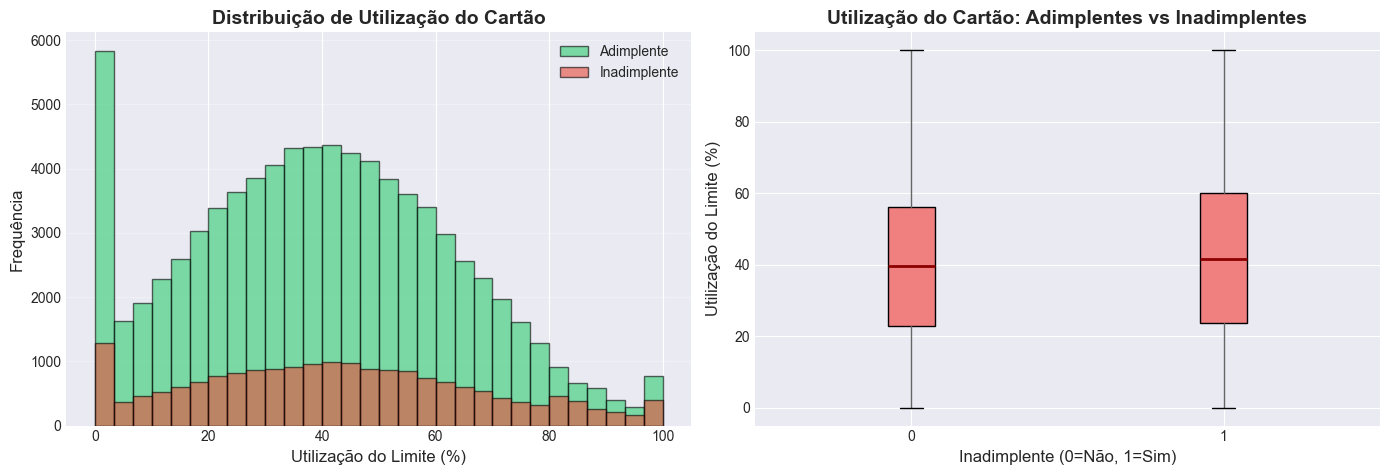

In [ ]:
# CÉLULA 8. UTILIZAÇÃO DE CARTÃO vs INADIMPLêNCIA
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
df[df['inadimplente'] == 0]['utilizacao_limite_cartao'].hist(bins=30, alpha=0.6, label='Adimplente', 
                                                               color='#2ecc71', ax=ax[0], edgecolor='black')
df[df['inadimplente'] == 1]['utilizacao_limite_cartao'].hist(bins=30, alpha=0.6, label='Inadimplente', 
                                                               color='#e74c3c', ax=ax[0], edgecolor='black')
ax[0].set_title('Distribuição de Utilização do Cartão', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Utilização do Limite (%)', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Boxplot
df.boxplot(column='utilizacao_limite_cartao', by='inadimplente', ax=ax[1], patch_artist=True,
           boxprops=dict(facecolor='lightcoral', color='black'),
           medianprops=dict(color='darkred', linewidth=2))
ax[1].set_title('Utilização do Cartão: Adimplentes vs Inadimplentes', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Inadimplente (0=Não, 1=Sim)', fontsize=12)
ax[1].set_ylabel('Utilização do Limite (%)', fontsize=12)
plt.suptitle('')

plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Sinal de alerta acima de 80%:** clientes com utilização >80% do limite têm **34.1% de chance de inadimplir** (quase o dobro da média). Inadimplentes usam 7.1% a mais do limite disponível.


---
# 4️⃣ VARIÁVEIS CATEGÓRICAS vs INADIMPLÊNCIA
---

🎓 ESCOLARIDADE vs INADIMPLÊNCIA

% de Inadimplentes por Escolaridade:
escolaridade
Fundamental      20.1
Médio            19.8
Superior         19.8
Pós-graduação    13.3
Name: 1, dtype: float64


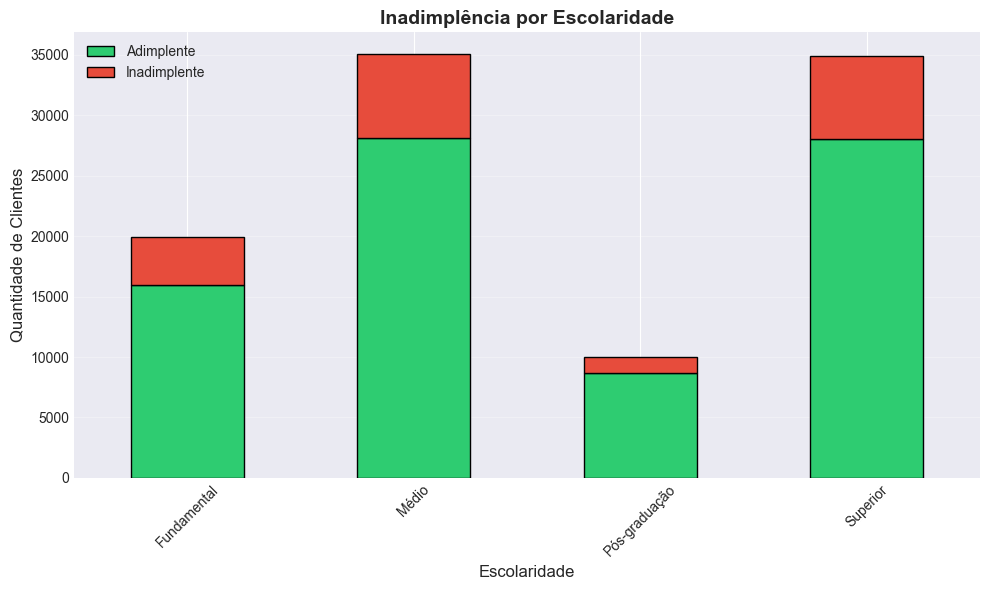

In [ ]:
# CÉLULA 9. ESCOLARIDADE vs INADIMPLÊNCIA
tabela = pd.crosstab(df['escolaridade'], df['inadimplente'], normalize='index') * 100

print("🎓 ESCOLARIDADE vs INADIMPLÊNCIA")
print("=" * 60)
print("\n% de Inadimplentes por Escolaridade:")
print(tabela[1].sort_values(ascending=False).round(1))

# Barras
tabela_count = pd.crosstab(df['escolaridade'], df['inadimplente'])
tabela_count.plot(kind='bar', stacked=True, figsize=(10, 6), 
                   color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.title('Inadimplência por Escolaridade', fontsize=14, fontweight='bold')
plt.xlabel('Escolaridade', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.legend(['Adimplente', 'Inadimplente'], loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Educação protege levemente:** Pós-graduação tem menor inadimplência (13.3%) vs Fundamental (20.1%). Porém, a diferença não é enorme.

---

💼 OCUPAÇÃO vs INADIMPLÊNCIA

% de Inadimplentes por Ocupação:
ocupacao
Desempregado    64.0
CLT             16.9
Autônomo        16.7
Empresário      16.6
Name: 1, dtype: float64


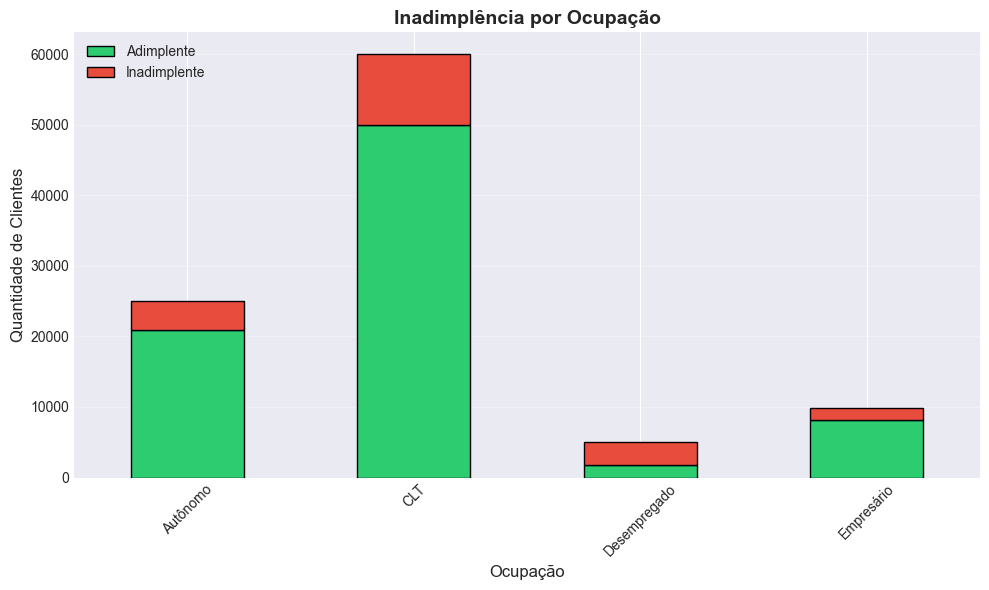

In [ ]:
# CÉLULA 10. OCUPAÇÃO vs INADIMPLÊNCIA
tabela = pd.crosstab(df['ocupacao'], df['inadimplente'], normalize='index') * 100

print("💼 OCUPAÇÃO vs INADIMPLÊNCIA")
print("=" * 60)
print("\n% de Inadimplentes por Ocupação:")
print(tabela[1].sort_values(ascending=False).round(1))

# Barras
tabela_count = pd.crosstab(df['ocupacao'], df['inadimplente'])
tabela_count.plot(kind='bar', stacked=True, figsize=(10, 6), 
                   color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.title('Inadimplência por Ocupação', fontsize=14, fontweight='bold')
plt.xlabel('Ocupação', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.legend(['Adimplente', 'Inadimplente'], loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Desemprego é o maior risco:** 64% dos desempregados são inadimplentes — **mais de 3x a taxa geral**. CLT, Autônomos e Empresários têm taxas similares (~17%), indicando que estabilidade de emprego é crítica.

---

💍 ESTADO CIVIL vs INADIMPLÊNCIA

% de Inadimplentes por Estado Civil:
estado_civil
Casado        19.4
Solteiro      19.1
Viúvo         19.0
Divorciado    19.0
Name: 1, dtype: float64


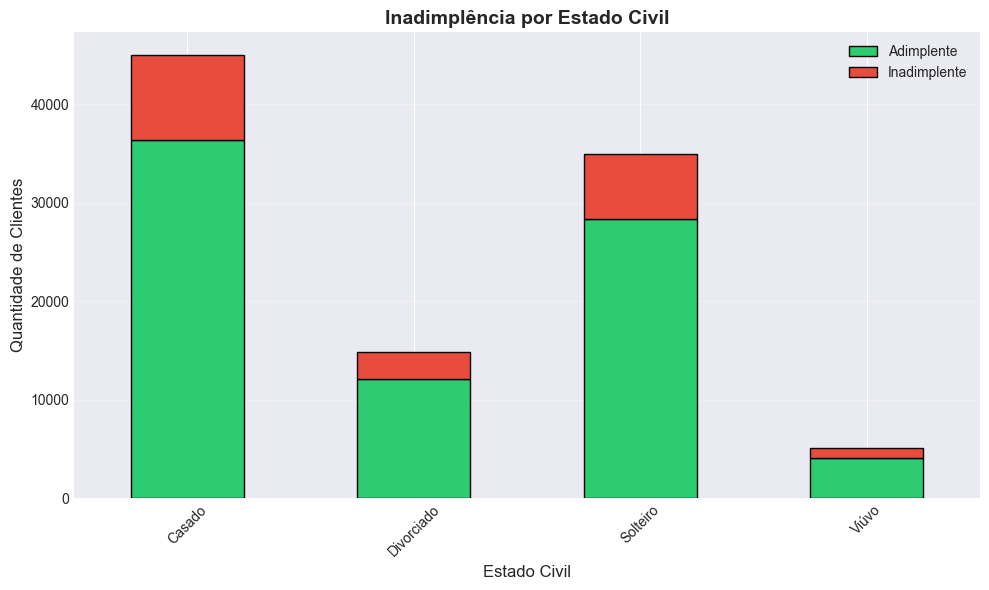

In [ ]:
# CÉLULA 11. ESTADO CIVIL vs INADIMPLÊNCIA
tabela = pd.crosstab(df['estado_civil'], df['inadimplente'], normalize='index') * 100

print("💍 ESTADO CIVIL vs INADIMPLÊNCIA")
print("=" * 60)
print("\n% de Inadimplentes por Estado Civil:")
print(tabela[1].sort_values(ascending=False).round(1))

# Barras
tabela_count = pd.crosstab(df['estado_civil'], df['inadimplente'])
tabela_count.plot(kind='bar', stacked=True, figsize=(10, 6), 
                   color=['#2ecc71', '#e74c3c'], edgecolor='black')
plt.title('Inadimplência por Estado Civil', fontsize=14, fontweight='bold')
plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.legend(['Adimplente', 'Inadimplente'], loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Estado civil tem baixo impacto:** taxas de inadimplência variam apenas entre 18.9% e 19.4%. Esta variável pode ser **descartada** no modelo final por baixo poder preditivo.

---

🎯 TOP 8 CORRELAÇÕES COM INADIMPLÊNCIA
 1. score_serasa_externo           ⬇️ NEGATIVA  | -0.197 🟢 FRACA
 2. historico_atraso_90_dias       ⬆️ POSITIVA  |  0.174 🟢 FRACA
 3. possui_imovel_proprio          ⬇️ NEGATIVA  | -0.164 🟢 FRACA
 4. renda_anual                    ⬇️ NEGATIVA  | -0.160 🟢 FRACA
 5. valor_patrimonio               ⬇️ NEGATIVA  | -0.125 🟢 FRACA
 6. tempo_emprego_atual            ⬇️ NEGATIVA  | -0.105 🟢 FRACA
 7. possui_carro                   ⬇️ NEGATIVA  | -0.070 🟢 FRACA
 8. utilizacao_limite_cartao       ⬆️ POSITIVA  |  0.047 🟢 FRACA


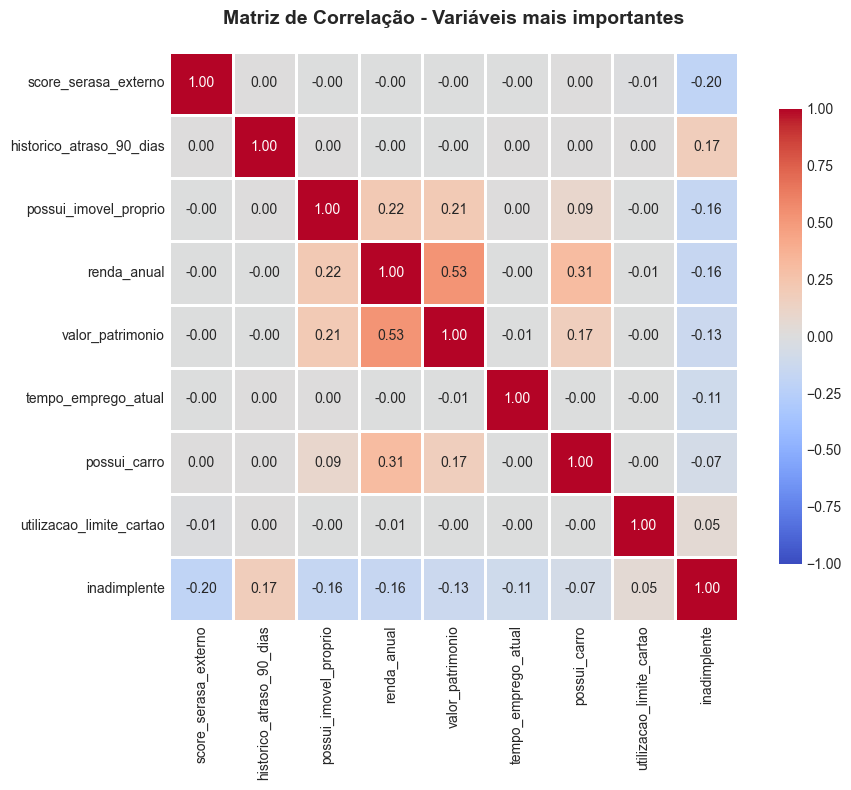

In [ ]:
# CÉLULA 12. CORRELAÇÃO COM O TARGET
df_numeric = df.select_dtypes(include=[np.number])
correlacao = df_numeric.corr()

print("🎯 TOP 8 CORRELAÇÕES COM INADIMPLÊNCIA")
print("=" * 60)

corr_target = correlacao['inadimplente'].drop('inadimplente').abs().sort_values(ascending=False)

for i, (var, valor) in enumerate(corr_target.head(8).items(), 1):
    direcao = "⬆️ POSITIVA" if correlacao.loc[var, 'inadimplente'] > 0 else "⬇️ NEGATIVA"
    forca = "🔴 FORTE" if valor > 0.5 else "🟡 MODERADA" if valor > 0.3 else "🟢 FRACA"
    print(f"{i:2}. {var:<30} {direcao:12} | {correlacao.loc[var, 'inadimplente']:>6.3f} {forca}")

# Heatmap das variáveis mais importantes
top_vars = corr_target.head(8).index.tolist() + ['inadimplente']
corr_top = df_numeric[top_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_top, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Matriz de Correlação - Variáveis mais importantes', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---

### 💡 INSIGHT

**Top 3 variáveis preditivas:**

1. **Score Serasa** (0.197) — maior correlação
2. **Histórico de Atrasos** (0.174) — comportamento passado prediz futuro
3. **Posse de Imóvel** (0.164) — patrimônio reduz risco

Juntas, essas variáveis devem ser priorizadas no modelo de ML.

---


# 6️⃣ DETECÇÃO DE OUTLIERS

---

📊 renda_anual: 6,201 outliers (6.2%)
📊 valor_patrimonio: 6,601 outliers (6.6%)
📊 score_serasa_externo: 0 outliers (0.0%)
📊 utilizacao_limite_cartao: 0 outliers (0.0%)
📊 idade: 0 outliers (0.0%)


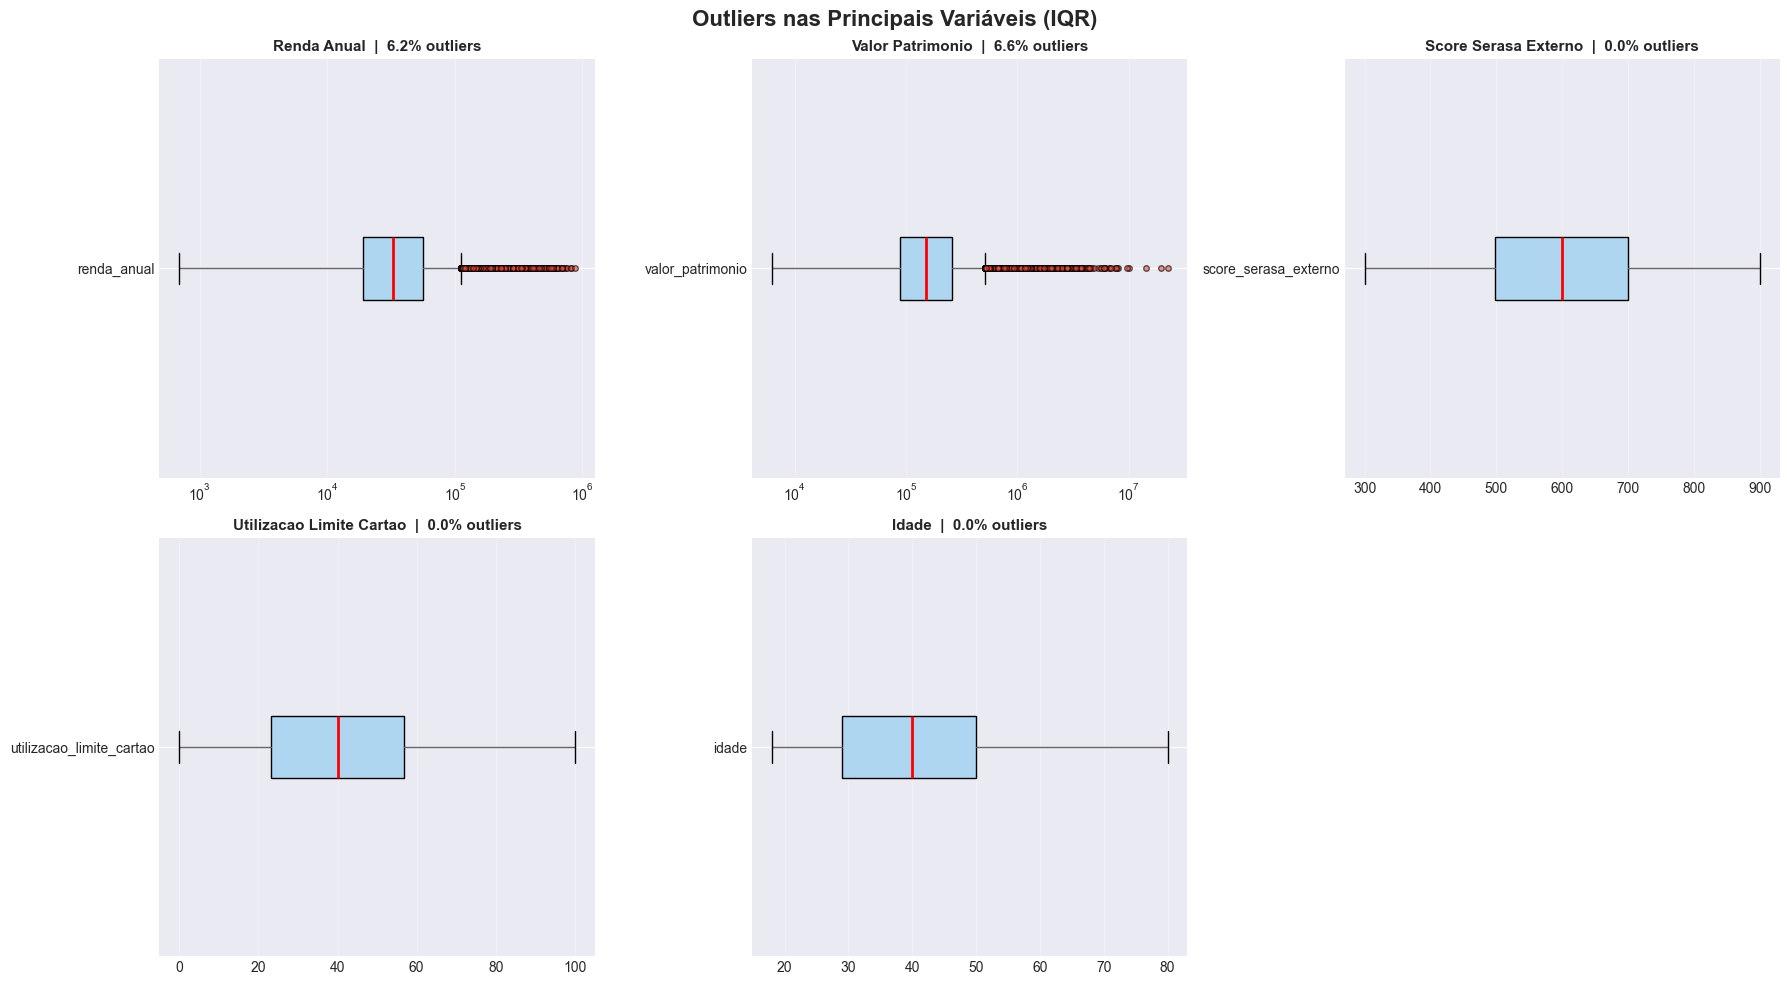

In [ ]:
# CÉLULA 13. OUTLIERS NAS PRINCIPAIS VARIÁVEIS
variaveis_importantes = ['renda_anual', 'valor_patrimonio', 'score_serasa_externo', 
                          'utilizacao_limite_cartao', 'idade']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variaveis_importantes):

    # IQR
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[var] < lower) | (df[var] > upper)]
    pct_outliers = len(outliers) / len(df) * 100

    # Boxplot
    df.boxplot(
        column=var,
        ax=axes[i],
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor='#AED6F1', edgecolor='black'),
        medianprops=dict(color='red', linewidth=2),
        flierprops=dict(marker='o', markersize=4, markerfacecolor='#E74C3C', alpha=0.6)
    )

    # Escala log para variáveis financeiras
    if var in ['renda_anual', 'valor_patrimonio']:
        axes[i].set_xscale('log')

    axes[i].set_title(
        f'{var.replace("_", " ").title()}  |  {pct_outliers:.1f}% outliers',
        fontsize=11,
        fontweight='bold'
    )

    axes[i].grid(axis='x', alpha=0.3)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    print(f"📊 {var}: {len(outliers):,} outliers ({pct_outliers:.1f}%)")

fig.delaxes(axes[-1])

plt.suptitle(
    'Outliers nas Principais Variáveis (IQR)',
    fontsize=16,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

---
### 💡 INSIGHT

**Outliers legítimos em renda/patrimônio:** 6% dos clientes têm valores extremos, mas representam casos reais (alta renda ou alto patrimônio). Manteremos no dataset, pois não são erros, mas **aplicaremos normalização** para não enviesar o modelo.

---

## EDA - RESUMO ⬇️

---

### 1. **Qualidade dos Dados**
- **0** valores nulos encontrados
- **0** duplicatas identificadas

### 2. **Target**
- **19.2%** de inadimplentes
- Dados **DESBALANCEADOS** (proporção 4:1)
- Estratégia de balanceamento: **SMOTE + Ajuste de pesos nas classes**

### 3. **Top 5 Variáveis Mais Importantes**

1. **Score Serasa** → Inadimplentes têm 72 pontos a menos.
2. **Histórico de Atrasos** → Quem atrasou antes tem 3x mais chance de falhar
3. **Posse de Imóvel** → Ter patrimônio reduz risco significativamente
4. **Renda Anual** → Inadimplentes ganham 56.7% menos
5. **Ocupação** → Desempregados têm 64% de inadimplência vs 17% dos empregados

### 4. **Hipóteses Principais para Testar no Modelo**
- **H1:** Clientes com score Serasa < **650** têm **2x** mais chance de falhar
- **H2:** Utilização de cartão > **80%** indica alto risco (34% inadimplência)
- **H3:** **Desempregados** têm 64% de inadimplência vs 17% média geral
- **H4:** Histórico de atrasos é preditor mais forte que renda (correlação 0.174)
- **H5:** Posse de imóvel + renda alta = perfil de baixíssimo risco

---



## 📦 Exportação de Insights (Suporte ao Dashboard Power BI)

Esta etapa gera arquivos auxiliares com os principais indicadores
identificados na EDA, que serão utilizados na documentação
e no dashboard interativo desenvolvido em Power BI.



In [ ]:
# CÉLULA 14. EXPORTAÇÃO DE INSIGHTS
import os
BASE_DIR = "../insights"
os.makedirs(BASE_DIR, exist_ok=True)

print("📦 Exportando insights da EDA para uso externo (Power BI / documentação)")

# Métricas gerais
total_clientes = len(df)
taxa_inadimplencia = round(df["inadimplente"].mean() * 100, 2)

qtd_variaveis_numericas = df_numeric.shape[1]
qtd_variaveis_categoricas = df.shape[1] - df_numeric.shape[1] - 1 # menos target

valores_nulos = int(df.isna().sum().sum())
duplicatas = df.duplicated().sum()

# Top 5 correlações
top_5_correlacoes = (
    correlacao["inadimplente"]
    .drop("inadimplente")
    .sort_values(ascending=False)
    .head(5)
)

# Salvar insights
output_path = f"{BASE_DIR}/insights_eda.txt"

with open(output_path, "w", encoding="utf-8") as f:
    f.write("=" * 80 + "\n")
    f.write("INSIGHTS DA ANÁLISE EXPLORATÓRIA DE DADOS (EDA)\n")
    f.write("=" * 80 + "\n\n")

    f.write(f"Total de clientes analisados: {total_clientes:,}\n")
    f.write(f"Taxa de inadimplência: {taxa_inadimplencia}%\n")
    f.write(f"Variáveis numéricas: {qtd_variaveis_numericas}\n")
    f.write(f"Variáveis categóricas: {qtd_variaveis_categoricas}\n")
    f.write(f"Valores nulos no dataset: {valores_nulos}\n")
    f.write(f"Duplicatas encontradas: {duplicatas}\n\n")

    f.write("Top 5 Variáveis Mais Relacionadas à Inadimplência (Correlação):\n")
    f.write("-" * 80 + "\n")
    for var, valor in top_5_correlacoes.items():
        f.write(f"{var:<30} | Correlação: {valor:.3f}\n")

print(f"➡️ Insights salvos em: {output_path}")

# Salvar matriz de correlação
correlacao_path = f"{BASE_DIR}/matriz_correlacao.csv"
correlacao.to_csv(correlacao_path)

print(f"➡️ Matriz de correlação salva em: {correlacao_path}")

📦 Exportando insights da EDA para uso externo (Power BI / documentação)
➡️ Insights salvos em: ../insights/insights_eda.txt
➡️ Matriz de correlação salva em: ../insights/matriz_correlacao.csv


---

## 🔍 O QUE APRENDI?

Este EDA revelou que **inadimplência não é aleatória** — há padrões claros:

✅ **Perfil de BAIXO RISCO:**
- Score Serasa > 650
- Renda > R$ 35.000/ano
- Empregado (CLT/Autônomo/Empresário)
- Utilização do cartão < 50%
- Possui imóvel próprio

❌ **Perfil de ALTO RISCO:**
- Score Serasa < 500
- Renda < R$ 23.000/ano
- Desempregado
- Utilização do cartão > 80%
- Histórico de atrasos > 2

---